In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import time
from scipy.interpolate import interp2d
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import torch.nn.init as init
import time
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [57]:
class Network(nn.Module):

  def __init__(self, width, depth, width_D, depth_D, activation, D_activation, N, N_data, device):
    super().__init__()
    # optimisers    

    # constants and stuff
    self.N = N
    self.N_data = N_data
    self.r_data, self.t_data = self.sample(self.N_data)
    self.c_numerical = torch.tensor(self.NumericalSoln(self.r_data.cpu().detach().numpy(), self.t_data.cpu().detach().numpy())).to(device)
    self.r0_boundary, self.rs_boundary, self.t_boundaries, self.t0_boundary, self.r_boundary = self.init_boundaries(N)
    self.j = -5.35e-5
    self.Rs = torch.tensor(2e-6)
    self.c_max = 4.665e4
    self.c0 = torch.tensor(2e4).view(-1, 1).to(device)
    self.D_ref = 2e-16
    self.C_theory = 277.84
    self.C_practical = 160

    # storing D and loss values
    self.Ds = []
    self.loss_list = []
    self.r0_loss_list = []
    self.rs_loss_list = []
    self.phys_loss_list = []
    self.comp_loss_list = []

    # nn constants
    #activation = nn.SELU
    #D_activation = nn.Tanh
    self.D_hidden = depth_D # number of neurons in hidden layers for D
    self.D_layers = width_D # number of hidden layers for D
    self.input = 2 # input is r and t
    self.output = 1 # output is c
    self.layers = width # number of hidden layers
    self.hidden = depth # number of neurons in hidden layers
    self.activation = activation

    # c network
    self.fci = nn.Sequential(*[nn.Linear(self.input, self.hidden), activation()])
    init.kaiming_normal_(self.fci[0].weight, nonlinearity='tanh')
    self.fch = nn.Sequential(*[nn.Sequential(*[nn.Linear(self.hidden, self.hidden), activation()]) for i in range(self.layers-1)])
    for layer in self.fch.children():
      if isinstance(layer, nn.Linear):
          init.kaiming_normal_(layer.weight, nonlinearity='tanh')
    self.fco = nn.Linear(self.hidden, self.output)

    # D network
    self.fciD = nn.Sequential(*[nn.Linear(1, self.D_hidden), D_activation()])
    init.kaiming_normal_(self.fciD[0].weight)
    self.fchD = nn.Sequential(*[nn.Sequential(*[nn.Linear(self.D_hidden, self.D_hidden), D_activation()]) for i in range(self.D_layers-1)])
    for layer in self.fchD.children():
      if isinstance(layer, nn.Linear):
          init.kaiming_normal_(layer.weight)
    self.fcoD = nn.Linear(self.D_hidden, 1)

  # c forward propagation
  def forward_c(self, x, t):
    x = torch.cat((x, t), dim = 1)
    x = self.fci(x)
    x = self.fch(x)
    x = self.fco(x)
    x = self.c0/self.c_max + t**0.5*x
    return x
  
  # D forward propagation
  def forward_D(self, x):
    x = self.fciD(x)
    x = self.fchD(x)
    x = self.fcoD(x)
    x = x*1e-13
    return x
  
  # numerical solution of spherical diffusion equation
  def NumericalSoln(self, r_data, t_data):

    numerical_sol = pd.read_csv("MATLAB Solver\data.csv")
    
    sol = []
    for i in range(len(r_data)):
      r = np.round(9999 * r_data[i]).astype(int)[0]
      t = np.round(399 * t_data[i]).astype(int)[0]  
      
      c = numerical_sol.iloc[r, t]
      sol.append(c)
    return sol
  
  
  def init_boundaries(self, N):

    # x and t boundary points for training x boundaries, x = 0,1, varying t values
    r0_boundary = torch.tensor(0.).repeat(N).view(-1, 1).requires_grad_(True).to(device)
    rs_boundary = torch.tensor(1.).repeat(N).view(-1, 1).requires_grad_(True).to(device)
    t_boundaries = torch.rand(N).view(-1, 1).requires_grad_(True).to(device)

    # 0 time boundary for training
    t0_boundary = torch.tensor(0.).repeat(N).view(-1, 1).requires_grad_(True).to(device)
    r_boundary = torch.rand(N).view(-1, 1).requires_grad_(True).to(device)

    return r0_boundary, rs_boundary, t_boundaries, t0_boundary, r_boundary

  def sample(self, N):
        
    # sample points for training
    r = torch.rand(N).view(-1, 1).requires_grad_(True).to(device).view(-1, 1)
    t = torch.rand(N).view(-1, 1).requires_grad_(True).to(device).view(-1, 1)

    return r, t

# adaptive sampling, unused due to VRAM limitations
  def adaptive_sample(self, N):
    
    r = torch.linspace(0.0001, 1, 2*N).requires_grad_(True).to(device)
    t = torch.linspace(0.0001, 1, 2*N).requires_grad_(True).to(device)
    r_grid, t_grid = torch.meshgrid(r, t)
    phys_loss = self.phys_loss(r_grid.flatten().unsqueeze(1), t_grid.flatten().unsqueeze(1))

    ids = torch.multinomial(phys_loss, N, replacement=True)
    r = r[ids]
    t = t[ids]

    print(r.shape, t.shape)

    return r, t

  def Diffusion_Coeff(self, c):

    SOC = (self.c_max - c)/self.c_max * self.C_theory/self.C_practical
    D = self.D_ref * (1 + 100*SOC**(3/2))

    return D
  
  def deriv_t(self, c, t):
    return torch.autograd.grad(c, t, grad_outputs=torch.ones_like(c).to(device), create_graph=True)[0]
  
  def deriv_r(self, c, r):
    return torch.autograd.grad(c, r, grad_outputs=torch.ones_like(c).to(device), create_graph=True)[0]
  
  def phys_loss(self, r, t):

    c = self.forward_c(r, t)
    c_r = self.deriv_r(c, r)
    c_rr = self.deriv_r(c_r, r)
    c_t = self.deriv_t(c, t)
    D = self.forward_D(c)
    Rs = self.Rs

    loss = (r**2*c_t - 2*r*D/Rs**2*c_r - r**2*D/Rs**2*c_rr)**2
    return loss

  def losses(self):
    
    r_phys, t_phys = self.sample(self.N)
    j, Rs, c_max, c0 = self.j, self.Rs, self.c_max, self.c0 

    # loss for r = 0 boundary
    c = self.forward_c(self.r0_boundary, self.t_boundaries)
    c_r = self.deriv_r(c, self.r0_boundary)
    r0_loss = c_r**2
    self.r0_loss_list.append(torch.mean(r0_loss).item())
    
    # loss for x = rs boundary
    c = self.forward_c(self.rs_boundary, self.t_boundaries)
    c_r = self.deriv_r(c, self.rs_boundary)
    D = self.forward_D(c)
    rs_loss = (D*c_r + j*Rs/c_max)**2
    self.rs_loss_list.append(torch.mean(rs_loss).item())

    # physics loss
    phys_loss = self.phys_loss(r_phys, t_phys)
    self.phys_loss_list.append(torch.mean(phys_loss).item())
    
    # comparative loss
    c = self.c_max*self.forward_c(self.r_data, self.t_data)
    comp_loss = 1/self.c_max*(torch.sub(c, self.c_numerical.unsqueeze(1)))**2
    self.comp_loss_list.append(torch.mean(comp_loss).item())

    loss = torch.mean(r0_loss) + 1e28*torch.mean(rs_loss) + 100*torch.mean(phys_loss) + 100*torch.mean(comp_loss)

    return loss
  
  def closure(self):
    self.optimizer_lbfgs.zero_grad()
    loss = self.losses()
    loss.backward()
    return loss
  
  def train(self, epochs_adam, lr_adam, epochs_lbfgs):

    # Adam
    optimizer_adam = torch.optim.Adam(self.parameters(), lr = lr_adam)
    times = []
    Ds = np.zeros((100, int(np.floor((epochs_adam+epochs_lbfgs)/200))))
    i = 0

    for epoch in range(epochs_adam):
      
      start_time = time.perf_counter()
      self.epoch = epoch
      
      optimizer_adam.zero_grad()
      loss = self.losses()
      self.loss_list.append(loss.item())
      loss.backward()
      optimizer_adam.step()
      #print(f'Epoch: {epoch}  Loss: {loss.item()}', end='\r')
      print(f'Activation: {self.activation}, Width: {self.layers}  Depth: {self.hidden}, D_Width: {self.D_layers}, D_Depth: {self.D_hidden},  Epoch: {self.epoch}  Loss: {loss.item()}', end='\r')
      end_time = time.perf_counter()
      times.append(end_time - start_time)

      if epoch % 600 == 0:

        D = self.forward_D(torch.linspace(0, 1, 100).view(-1, 1).to(device))
        D = D.cpu().detach().numpy()
        Ds[:, i:i+1] = D
        i+=1



    # LBFGS
    self.optimizer_lbfgs = torch.optim.LBFGS(self.parameters(), 
                                        max_iter=400, 
                                        history_size=400, 
                                        tolerance_grad=1.0 * np.finfo(float).eps, 
                                        tolerance_change=1.0 * np.finfo(float).eps, 
                                        line_search_fn='strong_wolfe')
    for epoch in range(epochs_lbfgs):

      start_time = time.perf_counter()
      loss = self.optimizer_lbfgs.step(self.closure)
      self.loss_list.append(loss.item())

      self.epoch = epochs_adam + epoch

      if np.isnan(loss.item()):
        break
      end_time = time.perf_counter()
      times.append(end_time - start_time)
      print(f'Activation: {self.activation}, Width: {self.layers}  Depth: {self.hidden}, D_Width: {self.D_layers}, D_Depth: {self.D_hidden},  Epoch: {self.epoch}  Loss: {loss.item()}', end='\r')
    D = self.forward_D(torch.linspace(0, 1, 100).view(-1, 1).to(device))
    D = D.cpu().detach().numpy()
    Ds[:, i:i+1] = D
      

    error_D = self.error_D()
    error_c = self.error()

    D = self.Diffusion_Coeff(np.linspace(0, self.c_max, 100))

    for i in range(Ds.shape[1]):
      plt.plot(np.linspace(0, self.c_max, 100), Ds[:, i], label=f'Epoch: {200*(i)}', alpha=0.5)
    plt.plot(np.linspace(0, self.c_max, 100), D, label='Numerical D', color='black')
    plt.legend()
    plt.yscale('log')
    plt.grid('True')
    plt.show()



    return self.loss_list, error_D, error_c, times

  def plot(self):

      X = torch.linspace(0, 1, 100).to(device)
      T = torch.linspace(0, 1, 100).to(device)
      X_grid, T_grid = torch.meshgrid(X, T)
      
      C = self.c_max*self.forward_c(X_grid.flatten().unsqueeze(1), T_grid.flatten().unsqueeze(1))
      C = C.view(100, 100)
      C = C.cpu().detach().numpy()
      
      X, T = np.meshgrid(self.Rs*X.cpu().detach().numpy(), 400*T.cpu().detach().numpy())

      fig = go.Figure(data=[go.Surface(z=C, x=X, y=T)])
      fig.update_layout(template = 'plotly_dark', 
                        title='Concentration vs Time and Radius', 
                        scene = dict(xaxis = dict(title = 'Radius'),
                        yaxis = dict(title = 'Time (s)'),
                        zaxis = dict(title = 'Concentration')),                        
                        autosize=False, width=800, height=600, margin=dict(l=50, r=50, t=50, b=50))
      fig.show()

  def error_D(self):

    c = torch.linspace(0, 1, 100).view(-1, 1).to(device)
    D = self.forward_D(c).cpu().detach().numpy()
    c = self.c_max*c.cpu().detach().numpy()
    D_SOC = self.Diffusion_Coeff(c)

    error_D = np.mean(np.sqrt((D - D_SOC)**2))

    return error_D


  def plot_loss(self):
    fig = px.scatter(
            x=range(len(self.loss_list)),
            y=self.loss_list,
            log_y=True,
            log_x=True,
            color=np.log(self.loss_list),
            color_continuous_scale="Agsunset",
            labels={"x": "Epochs", "y": "Loss"},
            template='plotly_dark'
        )
    fig.show()

    plt.plot(self.r0_loss_list, label='r0_loss')
    plt.plot(self.rs_loss_list, label='rs_loss')
    plt.plot(self.phys_loss_list, label='phys_loss')
    #plt.plot(self.comp_loss_list, label='comp_loss')
    plt.legend()
    plt.show()

  def plot_comparison(self):

    numerical = pd.read_csv("MATLAB Solver\data.csv")
    X = torch.linspace(0, 1, 100).to(device).requires_grad_(True)
    T = torch.linspace(0, 1, 100).to(device).requires_grad_(True)
    X_grid, T_grid = torch.meshgrid(X, T)

    C = self.c_max*self.forward_c(X_grid.flatten().unsqueeze(1), T_grid.flatten().unsqueeze(1))
    C = C.view(100, 100)
    C = C.cpu().detach().numpy()

    X = np.round(10000*X.cpu().detach().numpy())
    T = np.round(400*T.cpu().detach().numpy())

    fig = make_subplots(rows=2, cols=2, specs=[[{}, {}], [{}, {}]], subplot_titles=('Comparison at t=0', 'Comparison at t=end', 'Comparison at r=0', 'Comparison at r=end'))

    fig.add_trace(go.Scatter(y=numerical.iloc[:, 0], mode='lines', name='Numerical', showlegend=True, line=dict(color="#2EBFA5")), row=1, col=1)
    fig.add_trace(go.Scatter(x=X, y=C[:, 0], mode='lines', name='NN', showlegend=True, line=dict(color="#3590F3")), row=1, col=1)

    fig.add_trace(go.Scatter(y=numerical.iloc[:, -1], mode='lines', name='Numerical', showlegend=False, line=dict(color="#2EBFA5")), row=1, col=2)
    fig.add_trace(go.Scatter(x=X, y=C[:, -1], mode='lines', name='NN', showlegend=False, line=dict(color="#3590F3")), row=1, col=2)

    fig.add_trace(go.Scatter(y=numerical.iloc[0, :], mode='lines', name='Numerical', showlegend=False, line=dict(color="#2EBFA5")), row=2, col=1)
    fig.add_trace(go.Scatter(x=T, y=C[0, :], mode='lines', name='NN', showlegend=False, line=dict(color="#3590F3")), row=2, col=1)

    fig.add_trace(go.Scatter(y=numerical.iloc[-1, :], mode='lines', name='Numerical', showlegend=False, line=dict(color="#2EBFA5")), row=2, col=2)
    fig.add_trace(go.Scatter(x=T, y=C[-1, :], mode='lines', name='NN', showlegend=False, line=dict(color="#3590F3")), row=2, col=2)

    fig.update_layout(autosize=False, width=800, height=600, margin=dict(l=50, r=50, t=50, b=50), showlegend=True, template = 'plotly_dark')

    fig.show()
      
  def error(self):
    
    X = torch.linspace(0, 0.99, 101).to(device).requires_grad_(True)
    T = torch.linspace(0, 0.99, 101).to(device).requires_grad_(True)
    X_grid, T_grid = torch.meshgrid(X, T)
    C = self.forward_c(X_grid.flatten().unsqueeze(1), T_grid.flatten().unsqueeze(1))
    C = self.c_max*C.view(101, 101)
    X_int = np.round(10000*X.cpu().detach().numpy()).astype(int)
    T_int = np.round(400*T.cpu().detach().numpy()).astype(int)

    numerical = pd.read_csv("MATLAB Solver\data.csv").to_numpy()
    numerical = numerical[np.ix_(X_int, T_int)]

    abs_error = np.mean(np.sqrt((numerical - C.cpu().detach().numpy())**2))
    
    return abs_error
    


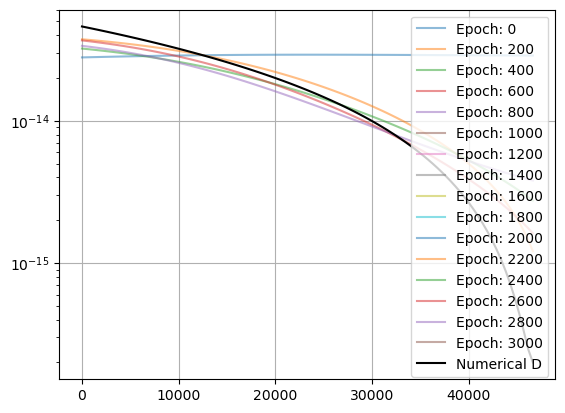

In [58]:
torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pinn = Network(10, 64, 5, 16, nn.SELU, nn.Tanh, 100, 100, device).to(device)

loss, error_D, error_c, times = pinn.train(3000, 1e-4, 300)